### Screening processing 

In [8]:
import os
import json
import csv
import re
from typing import List, Optional
from urllib.parse import urljoin
from statistics import mean, stdev

import requests
from bs4 import BeautifulSoup

from groo.groo import get_root


BASE_URL = "http://141.5.101.169/screening_task/data/"
ROOT_FOLDER = get_root(".root_jacobs")
OUTPUT_FOLDER = os.path.join(ROOT_FOLDER, "g-casa_screening_task", "outputs")
OUTPUT_FILE = "screening_results.csv"
REQUEST_TIMEOUT = 15  # seconds


# =========================
# Helpers
# =========================
def is_bool_list(x) -> bool:
    return isinstance(x, list) and all(isinstance(v, bool) for v in x)

def detect_version_and_finalize_trials(arr) -> Optional[List[bool]]:
    # New version: a single list of bools
    if is_bool_list(arr):
        return arr
    # Old version: two equal-length lists of bools
    if (
        isinstance(arr, list)
        and len(arr) == 2
        and is_bool_list(arr[0])
        and is_bool_list(arr[1])
        and len(arr[0]) == len(arr[1])
    ):
        return [a and b for a, b in zip(arr[0], arr[1])]
    return None

def accuracy(final_trials: List[bool]) -> float:
    return (sum(1 for v in final_trials if v) / len(final_trials)) if final_trials else 0.0

def valid_subid(subid: str) -> bool:
    """Accept only participant IDs that are exactly 6 alphanumeric characters."""
    return bool(re.fullmatch(r"[A-Za-z0-9]{6}", subid))


# =========================
# Remote fetchers
# =========================
def list_remote_json_files(base_url: str) -> List[str]:
    resp = requests.get(base_url, timeout=REQUEST_TIMEOUT)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    return [urljoin(base_url, a["href"]) for a in soup.find_all("a")
            if a.get("href", "").endswith(".json")]

def fetch_json(url: str) -> Optional[dict]:
    try:
        resp = requests.get(url, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        return resp.json()
    except Exception as e:
        print(f"[WARNING] Failed to fetch {url}: {e}")
        return None


# =========================
# Core processing
# =========================
def process_record(data: dict, source_name: str = "") -> Optional[dict]:
    subid = data.get("subid")
    if not subid or not valid_subid(subid):
        print(f"[INFO] Skipping invalid participant ID ({subid}) in: {source_name}")
        return None

    color_raw = data.get("color")
    shape_raw = data.get("shape")
    if color_raw is None or shape_raw is None:
        print(f"[WARNING] Missing color/shape in: {source_name}")
        return None

    color_trials = detect_version_and_finalize_trials(color_raw)
    shape_trials = detect_version_and_finalize_trials(shape_raw)
    if color_trials is None or shape_trials is None:
        print(f"[WARNING] Unrecognized data structure in: {source_name}")
        return None

    color_acc = accuracy(color_trials)
    shape_acc = accuracy(shape_trials)
    total_trials = len(color_trials) + len(shape_trials)
    correct_trials = sum(color_trials) + sum(shape_trials)
    overall_acc = (correct_trials / total_trials) if total_trials else 0.0

    return {
        "subid": subid,
        "color_accuracy": round(color_acc, 4),
        "shape_accuracy": round(shape_acc, 4),
        "overall_accuracy": round(overall_acc, 4),
    }


def print_apa_table(results: List[dict]) -> None:
    """
    Prints an APA-style descriptive table of means and SDs for accuracies.
    Columns: Measure | M | SD | N
    Values formatted to 3 decimals, SD shown as '—' if N < 2.
    """
    def desc(key: str):
        vals = [r[key] for r in results]
        n = len(vals)
        m = mean(vals) if n else 0.0
        sd = stdev(vals) if n > 1 else None
        return m, sd, n

    rows = [
        ("Color accuracy",) + desc("color_accuracy"),
        ("Shape accuracy",) + desc("shape_accuracy"),
        ("Overall accuracy",) + desc("overall_accuracy"),
    ]

    # Header
    title = "Table 1\nDescriptive statistics for screening accuracies"
    print("\n" + title)
    print("-" * max(len(title), 48))

    # Table body
    col1_w = 18
    print(f"{'Measure':<{col1_w}}  {'M':>8}  {'SD':>8}  {'N':>4}")
    print(f"{'-'*col1_w}  {'-'*8}  {'-'*8}  {'-'*4}")

    for label, m, sd, n in rows:
        m_str = f"{m:.3f}"
        sd_str = f"{sd:.3f}" if sd is not None else "—"
        print(f"{label:<{col1_w}}  {m_str:>8}  {sd_str:>8}  {n:>4}")


def main():
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    results: List[dict] = []

    print(f"[INFO] Listing remote JSON files from {BASE_URL} ...")
    try:
        json_urls = list_remote_json_files(BASE_URL)
    except Exception as e:
        print(f"[ERROR] {e}")
        return

    print(f"[INFO] Found {len(json_urls)} JSON files. Fetching & processing...")
    for url in json_urls:
        data = fetch_json(url)
        if data is None:
            continue
        row = process_record(data, source_name=url)
        if row:
            results.append(row)

    if results:
        output_path = os.path.join(OUTPUT_FOLDER, OUTPUT_FILE)
        with open(output_path, 'w', newline='') as csvfile:
            fieldnames = ["number", "subid", "color_accuracy", "shape_accuracy", "overall_accuracy"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for idx, row in enumerate(results, start=1):
                writer.writerow({"number": idx, **row})

            # Mean row
            mean_color = sum(r["color_accuracy"] for r in results) / len(results)
            mean_shape = sum(r["shape_accuracy"] for r in results) / len(results)
            mean_overall = sum(r["overall_accuracy"] for r in results) / len(results)
            writer.writerow({
                "number": "",
                "subid": "MEAN",
                "color_accuracy": round(mean_color, 4),
                "shape_accuracy": round(mean_shape, 4),
                "overall_accuracy": round(mean_overall, 4),
            })

        print(f"\n[OK] Results saved to {output_path}")
        print(f"[OK] Mean overall accuracy across {len(results)} participants: {round(mean_overall, 4)}")

        # APA-style table printout
        print_apa_table(results)

                # -------------------------------------------
        # Extra: how many did NOT score 100%?
        # -------------------------------------------
        not100_color = [r["subid"] for r in results if r["color_accuracy"] < 1.0]
        not100_shape = [r["subid"] for r in results if r["shape_accuracy"] < 1.0]

        print("\n[INFO] Screening failures:")
        print(f"Color < 100%: {len(not100_color)} participants")
        if not100_color:
            print("  IDs:", ", ".join(not100_color))
        print(f"Shape < 100%: {len(not100_shape)} participants")
        if not100_shape:
            print("  IDs:", ", ".join(not100_shape))

if __name__ == "__main__":
    main()

[INFO] Listing remote JSON files from http://141.5.101.169/screening_task/data/ ...
[INFO] Found 146 JSON files. Fetching & processing...
[INFO] Skipping invalid participant ID (Mariam_Screenshot_for_Manuscript) in: http://141.5.101.169/screening_task/data/Mariam_Screenshot_for_Manuscript.json
[INFO] Skipping invalid participant ID (test-ondrej) in: http://141.5.101.169/screening_task/data/test-ondrej.json

[OK] Results saved to /Users/giancarlodeiana/Desktop/root_folder/g-casa_screening_task/outputs/screening_results.csv
[OK] Mean overall accuracy across 144 participants: 0.9635

Table 1
Descriptive statistics for screening accuracies
-------------------------------------------------------
Measure                    M        SD     N
------------------  --------  --------  ----
Color accuracy         0.962     0.078   144
Shape accuracy         0.965     0.092   144
Overall accuracy       0.964     0.069   144

[INFO] Screening failures:
Color < 100%: 30 participants
  IDs: 0CV6D0, 5M

Plot screening results

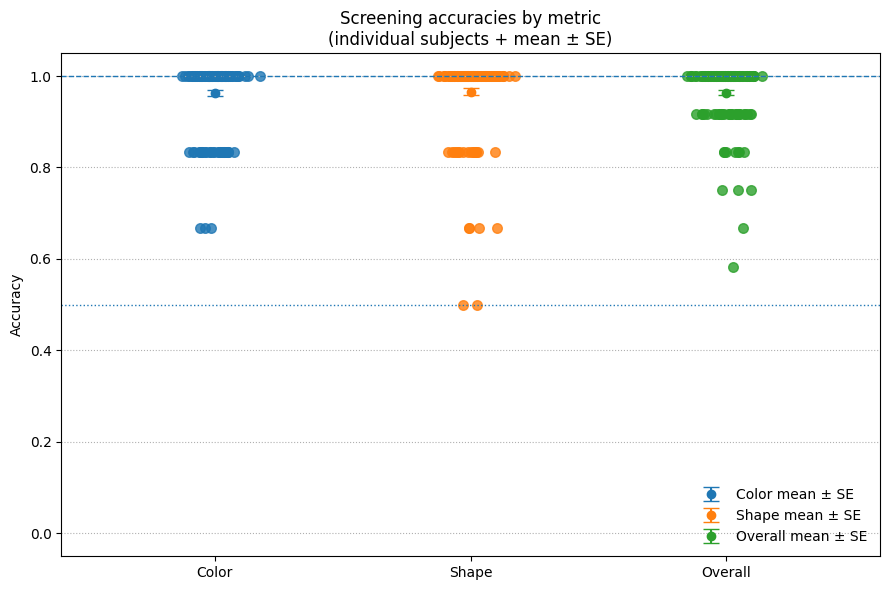

[OK] Saved figure to: /Users/giancarlodeiana/Desktop/root_folder/g-casa_screening_task/outputs/screening_plot_overview.png


In [14]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from groo.groo import get_root

# ---------- Load results from project root ----------
ROOT_FOLDER = get_root(".root_jacobs")
CSV_PATH = os.path.join(ROOT_FOLDER, "g-casa_screening_task", "outputs", "screening_results.csv")

color, shape, overall = [], [], []
with open(CSV_PATH, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        # skip the summary row
        if row["subid"].strip().upper() == "MEAN":
            continue
        color.append(float(row["color_accuracy"]))
        shape.append(float(row["shape_accuracy"]))
        overall.append(float(row["overall_accuracy"]))

if not color:
    raise ValueError("No participant rows found in CSV (did you run the screening script first?).")

# ---------- Helper for mean ± SE ----------
def mean_se(vals):
    m = float(np.mean(vals))
    se = float(np.std(vals, ddof=1) / math.sqrt(len(vals))) if len(vals) > 1 else float("nan")
    return m, se

# ---------- Prep data in 'long' form for plotting ----------
metrics = {
    "Color":   np.array(color, dtype=float),
    "Shape":   np.array(shape, dtype=float),
    "Overall": np.array(overall, dtype=float),
}

labels = list(metrics.keys())               # ["Color", "Shape", "Overall"]
x_pos  = np.arange(len(labels), dtype=float)  # [0,1,2]

# ---------- Build the figure ----------
plt.figure(figsize=(9, 6))

# Reference lines (helps orient the eye)
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle=":", linewidth=1)

# Beeswarm-style jittered points per metric + mean ± SE
rng = np.random.default_rng(42)
jitter_sd = 0.06  # adjust for more/less spread
dot_size  = 48

for i, label in enumerate(labels):
    vals = metrics[label]
    xs = rng.normal(loc=x_pos[i], scale=jitter_sd, size=len(vals))
    # individual subjects
    plt.scatter(xs, vals, s=dot_size, alpha=0.8)

    # mean ± SE
    m, se = mean_se(vals)
    plt.errorbar(
        [x_pos[i]], [m], yerr=[se],
        fmt="o", capsize=6, elinewidth=1.5, linewidth=0,  # linewidth=0 makes only the marker visible
        label=f"{label} mean ± SE"
    )

# Cosmetics
plt.ylabel("Accuracy")
plt.title("Screening accuracies by metric\n(individual subjects + mean ± SE)")
plt.xticks(x_pos, labels)
plt.ylim(-0.05, 1.05)
plt.xlim(-0.6, len(labels)-0.4)
plt.grid(axis="y", linestyle=":", linewidth=0.8)
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()

# Optional: save next to the CSV for easy sharing
out_dir = os.path.join(ROOT_FOLDER, "g-casa_screening_task", "outputs")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "screening_plot_overview.png")
plt.savefig(out_path, dpi=200)
plt.show()

print(f"[OK] Saved figure to: {out_path}")
